In [0]:
import torch
import sklearn.datasets as datasets
import keras.utils as utils
import torch.autograd as autograd
import torch.distributions as distributons
import matplotlib.pyplot as plt
import time

In [0]:
BATCH_SIZE = 512
EPOCH_NUMBER = 2000

In [0]:
# load iris dataset
iris = datasets.load_iris()
data_x = iris.data
data_y = utils.to_categorical(iris.target)
data_x = autograd.Variable(torch.from_numpy(data_x))
data_y = autograd.Variable(torch.from_numpy(data_y))

In [0]:
 class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.layer1 = torch.nn.Linear(4, 10)
        self.layer2 = torch.nn.Linear(10, 10)
        self.layer3 = torch.nn.Linear(10, 3)
        self.sigmoid=torch.nn.Sigmoid()
        self.relu=torch.nn.ReLU()
        #self.dropout = torch.nn.Dropout(p=0.5, inplace=False)
        
    def forward(self,x):
        layer1_output = self.relu(self.layer1(x))
        layer2_output = self.relu(self.layer2(layer1_output))
        predict = self.sigmoid(self.layer3(layer2_output))
        return predict

In [0]:
class SimulatedAnnealing(torch.optim.Optimizer):
    def __init__(self, params, T, annealing_rate, max_iterations):
        defaults = dict(T=T, annealing_rate=annealing_rate, max_iterations=max_iterations)
        super(SimulatedAnnealing, self).__init__(params, defaults)
        
    def step(self, closure=None):
        current_loss = closure()  
        
        for group in self.param_groups:
            max_iterations = group['max_iterations']
            annealing_rate = group['annealing_rate']
            norm_dist = distributons.Normal(torch.tensor(0.0), torch.tensor(0.1))
            for i in range(max_iterations):
              current_params = []
              for p in group['params']:
                  current_params.append(p.clone())      
                  # shift params
                  param_shift = norm_dist.sample(p.data.size())
                  p.data.add_(param_shift)

              next_loss = closure()
              
              if next_loss.item() > current_loss.item():
                if group['T'] != 0:
                  alpha = torch.exp((current_loss - next_loss) / group['T'])
                  u = distributons.Uniform(0, 1).sample(alpha.size())
                  if alpha < u:
                    # restore params
                    for p, p_last in zip(group['params'], current_params):
                      p.data = p_last.data
                    group['T'] = group['T'] * group['annealing_rate']
                    T = group['T']
                    return current_loss, T
                  
                  group['T'] = group['T'] * group['annealing_rate']
                  T = group['T']
                  return next_loss, T
                else:
                  # restore params
                  for p, p_last in zip(group['params'], current_params):
                    p.data = p_last.data
                  group['T'] = group['T'] * group['annealing_rate']
                  T = group['T']
                  return current_loss, T
              else:
                group['T'] = group['T'] * group['annealing_rate']
                T = group['T']
                return next_loss, T
                  

In [0]:
my_model = MyModel()
optimizer = SimulatedAnnealing(my_model.parameters(), 100, 0.9, 1)
cost_function = torch.nn.BCELoss()

In [197]:
loss_arr = []
temp_arr = []
# training step
start = time.time()
for epoch in range(EPOCH_NUMBER):
    permutation = torch.randperm(data_x.size()[0])
    for i in range(0,data_x.size()[0], BATCH_SIZE):
        element_ind = permutation[i : i + BATCH_SIZE]
        batch_x, batch_y = data_x[element_ind], data_y[element_ind]
        # define closure function
        def closure():
          predict_y = my_model(batch_x.float())
          loss = cost_function(predict_y,batch_y)
          optimizer.zero_grad()
          loss.backward()
          return loss
        loss_tensor, temp = optimizer.step(closure)
    loss_arr.append(float(loss_tensor))
    temp_arr.append(temp)
    print('Epoch number ' + str(epoch) + ', loss value ' + str(loss_tensor) + \
          ', temperature: ' + str(temp))
finish = time.time()
print('Time taken to train: ' + str(finish-start))

Epoch number 0, loss value tensor(0.6915, grad_fn=<BinaryCrossEntropyBackward>), temperature: 90.0
Epoch number 1, loss value tensor(0.6958, grad_fn=<BinaryCrossEntropyBackward>), temperature: 81.0
Epoch number 2, loss value tensor(0.7113, grad_fn=<BinaryCrossEntropyBackward>), temperature: 72.9
Epoch number 3, loss value tensor(0.7568, grad_fn=<BinaryCrossEntropyBackward>), temperature: 65.61000000000001
Epoch number 4, loss value tensor(0.8057, grad_fn=<BinaryCrossEntropyBackward>), temperature: 59.049000000000014
Epoch number 5, loss value tensor(0.8876, grad_fn=<BinaryCrossEntropyBackward>), temperature: 53.144100000000016
Epoch number 6, loss value tensor(1.0784, grad_fn=<BinaryCrossEntropyBackward>), temperature: 47.829690000000014
Epoch number 7, loss value tensor(1.1901, grad_fn=<BinaryCrossEntropyBackward>), temperature: 43.04672100000001
Epoch number 8, loss value tensor(0.9331, grad_fn=<BinaryCrossEntropyBackward>), temperature: 38.742048900000015
Epoch number 9, loss value 

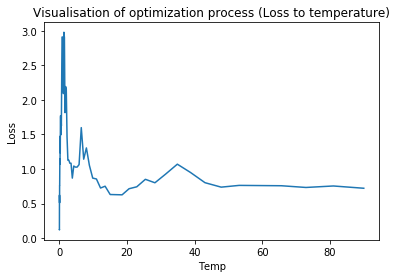

Result loss value: 0.11935622990131378


In [147]:
plt.plot(temp_arr, loss_arr)
plt.xlabel('Temp')
plt.ylabel('Loss')
plt.title('Visualisation of optimization process (Loss to temperature)')
plt.show()
print('Result loss value: ' + str(loss_arr[-1]))